In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

In [6]:
data = pd.read_csv('../Datasets/Sentiment.csv')
data = data[['text','sentiment']]

In [7]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [8]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [9]:
data.head()

,text,sentiment
0,rt nancyleegrahn how did everyone feel about t...,Neutral
1,rt scottwalker didnt catch the full gopdebate ...,Positive
2,rt tjmshow no mention of tamir rice and the go...,Neutral
3,rt robgeorge that carly fiorina is trending h...,Positive
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive


In [10]:
print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)
print(data[ data['sentiment'] == 'Neutral'].size)

4472
16986
6284


<Axes: xlabel='sentiment'>

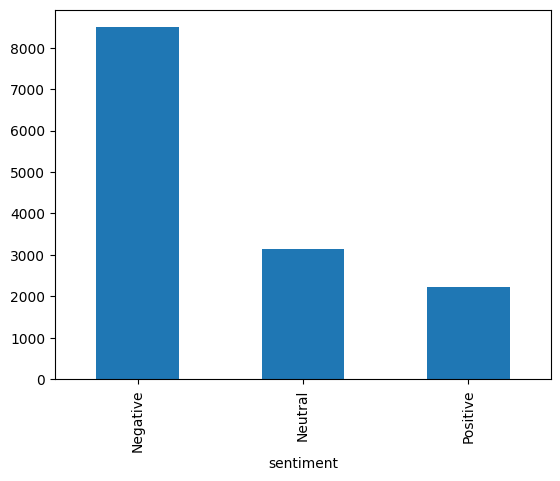

In [12]:
data.sentiment.value_counts().plot(kind="bar") #unbalanced dataset

<Axes: ylabel='Frequency'>

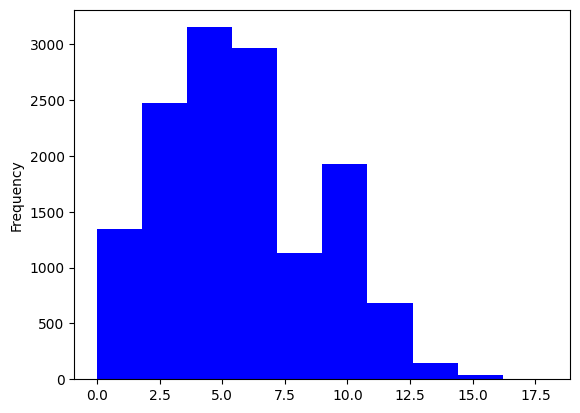

In [16]:
temp = data.copy()
stop_words = set(stopwords.words('english'))
temp['stop_words'] = temp['text'].apply(lambda x: len([x for x in x.split() if x in stop_words]))
temp['stop_words'].plot(kind='hist', color='blue')


In [24]:
data['text'] = data['text'].apply(lambda x: x.replace('rt',''))
data.head()

,text,sentiment
0,nancyleegrahn everyone feel climate change qu...,Neutral
1,scottwalker didnt catch full gopdebate last n...,Positive
2,tjmshow mention tamir rice gopdebate held cle...,Neutral
3,robgeorge carly fiorina trending hour debate ...,Positive
4,danscavino gopdebate w realdonaldtrump delive...,Positive


In [19]:
#Data Prepprocessing functions

def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(text)

def remove_stop_words(text):
    text = [i for i in str(text).split() if i not in stop_words]
    return " ".join(text)

def remove_numbers(text):
    text = "".join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    text = text.split()

    text = [i.lower() for i in text]
    return " ".join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : remove_stop_words(text))
    df.text=df.text.apply(lambda text : remove_numbers(text))
    df.text=df.text.apply(lambda text : Removing_punctuations(text))
    df.text=df.text.apply(lambda text : Removing_urls(text))
    df.text=df.text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= remove_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence


In [ ]:
normalized_sentence("My Name is Rythm. @Tweets,  plays 2025  INDIA_")

'name rythm tweet play india'

In [25]:
normalize_text(data)

,text,sentiment
0,nancyleegrahn everyone feel climate change que...,Neutral
1,scottwalker didnt catch full gopdebate last ni...,Positive
2,tjmshow mention tamir rice gopdebate held clev...,Neutral
3,robgeorge carly fiorina trending hour debate m...,Positive
4,danscavino gopdebate w realdonaldtrump deliver...,Positive
...,...,...
13866,cappy yarbrough love see men never faced pregn...,Negative
13867,georgehenryw thought huckabee exceeded expecta...,Positive
13868,lrihendry tedcruz president always tell truth ...,Positive
13869,jrehling gopdebate donald trump say doesnt tim...,Negative


In [42]:
X_train , X_temp,y_train , y_temp = train_test_split(data['text'],data['sentiment'], test_size=0.4, random_state=42)
X_val , X_test,y_val , y_test = train_test_split(X_temp,y_temp, test_size=0.5, random_state=42)


In [43]:
X_train

8157     glennbeck patandstu foxnews worst didnt apprec...
6830     mrlxc well kasich gay wedding whats next huge ...
6590     greatnessnyou opinion abound last night gop de...
11868    rwsurfergirl fox cherry picking candidate jeb ...
8116     jarjarbug cary fiorina top tier last night thi...
                               ...                        
5191     love gopdebate take mamasbarnyc hair look grea...
13418    monaeltahawy whererwomen im cairo often rail v...
5390     interesting every one gop candidate hate govt ...
860      chris christie tried wrap giulianistyle gopdeb...
7270     dabneypoe ohhhh bencarson honesty beautiful so...
Name: text, Length: 8322, dtype: object

In [44]:
y_train

8157     Negative
6830      Neutral
6590      Neutral
11868    Negative
8116      Neutral
           ...   
5191     Positive
13418    Negative
5390     Negative
860      Negative
7270     Positive
Name: sentiment, Length: 8322, dtype: object

sentiment
Negative    1693
Neutral      612
Positive     469
Name: count, dtype: int64

In [34]:
X_test

13299    rwsurfergirl jeb bush reminds elevator music h...
2271     dubinpeter httpstcowbolqwptqa paralegalgeorge ...
3254            alocalgyro worried america right gopdebate
10460    marymauldin hey foxnews absolutely fearful sen...
2676     scott walker chooses killing mother rather abo...
                               ...                        
6890     realdonaldtrump see gopdebate foxdebate foxnew...
5792     expectation ever prez rehearsal reaching walle...
2631     lizzwinstead boring match dot com profile ever...
10490    goldietaylor commercial break gopdebates httpt...
8868     rwsurfergirl american people pick next preside...
Name: text, Length: 2775, dtype: object

In [50]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)


In [51]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [52]:
print(y_train)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [53]:
print(y_test)

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [54]:
print(y_val)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [55]:
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train,X_test]))

In [56]:
tokenizer.word_index

{'UNK': 1,
 'gopdebate': 2,
 'gopdebates': 3,
 'trump': 4,
 'rwsurfergirl': 5,
 'fox': 6,
 'debate': 7,
 'candidate': 8,
 'realdonaldtrump': 9,
 'amp': 10,
 'news': 11,
 'night': 12,
 'last': 13,
 'gop': 14,
 'like': 15,
 'question': 16,
 'people': 17,
 'megynkelly': 18,
 'get': 19,
 'dont': 20,
 'foxnews': 21,
 'jeb': 22,
 'one': 23,
 'bush': 24,
 'republican': 25,
 'think': 26,
 'would': 27,
 'im': 28,
 'need': 29,
 'want': 30,
 'president': 31,
 'god': 32,
 'chris': 33,
 'donald': 34,
 'woman': 35,
 'right': 36,
 'ask': 37,
 'say': 38,
 'cruz': 39,
 'time': 40,
 'rubio': 41,
 'really': 42,
 'u': 43,
 'wallace': 44,
 'carson': 45,
 'know': 46,
 'said': 47,
 'next': 48,
 'tonight': 49,
 'watching': 50,
 'huckabee': 51,
 'job': 52,
 'american': 53,
 'tedcruz': 54,
 'see': 55,
 'doesnt': 56,
 'didnt': 57,
 'anyone': 58,
 'fair': 59,
 'pay': 60,
 'look': 61,
 'state': 62,
 'trying': 63,
 'go': 64,
 'thing': 65,
 'make': 66,
 'talk': 67,
 'good': 68,
 'megyn': 69,
 'hillary': 70,
 'face':

In [57]:
tokenizer.word_counts

OrderedDict([('glennbeck', 4),
             ('patandstu', 3),
             ('foxnews', 485),
             ('worst', 22),
             ('didnt', 222),
             ('appreciate', 9),
             ('theatrics', 4),
             ('thats', 108),
             ('gopdebates', 4211),
             ('mrlxc', 1),
             ('well', 128),
             ('kasich', 145),
             ('gay', 57),
             ('wedding', 22),
             ('whats', 30),
             ('next', 262),
             ('huge', 21),
             ('news', 752),
             ('gopdebate', 7226),
             ('huckabee', 250),
             ('going', 154),
             ('name', 50),
             ('black', 79),
             ('peopl', 1),
             ('greatnessnyou', 1),
             ('opinion', 22),
             ('abound', 1),
             ('last', 725),
             ('night', 749),
             ('gop', 604),
             ('debate', 977),
             ('america', 184),
             ('starving', 1),
             ('authentic',

In [58]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(sequences_train)

[[2539, 3078, 21, 722, 57, 1438, 2540, 166, 3], [6003, 139, 106, 315, 723, 560, 48, 755, 11, 2, 51, 94, 347, 222, 6004], [6005, 724, 6006, 13, 12, 14, 7, 78, 6007, 3079, 1026, 159, 594], [5, 6, 197, 186, 8, 22, 19, 177, 16, 3, 3], [6008, 3934, 160, 369, 2191, 13, 12, 26, 1241, 14, 756, 112, 1439, 223], [6009, 241, 6010, 2, 6011, 196, 1027, 6012, 1733], [77, 973, 285, 113, 2541, 3935, 3], [478, 6013, 1440, 380, 18, 1927, 926, 25, 60, 2], [2542, 6014, 2, 227, 1155, 2543, 3936, 6015], [269, 4, 270, 154, 3], [974, 21, 840, 3, 319, 6016, 8, 887, 288, 1559], [5, 53, 17, 107, 48, 31, 125, 62, 6, 11, 2, 3], [5, 54, 9, 29, 74, 276, 7, 2, 3], [359, 336, 3, 216, 271, 370, 48], [6017, 702, 6018, 1928, 1560, 247, 3080, 1081, 841, 3], [3081, 371, 469, 618, 2544, 25, 6019, 2545, 618, 1929, 888, 248, 98], [2, 260, 61, 6020, 20, 46, 108, 415, 129, 1734, 63, 643, 1082, 3], [2546, 296, 975, 435, 262, 206, 1441, 3082, 456, 3083, 58, 664, 2, 1442], [3084, 34, 64, 703, 3937, 110, 360, 3], [6021, 479, 2, 173

In [60]:
max_len = max([len(x) for x in data['text'].values])
max_len

130

In [61]:
X_train = pad_sequences(sequences_train,maxlen=300,padding='pre')
X_test = pad_sequences(sequences_test,maxlen=300,padding='pre')
X_val = pad_sequences(sequences_val,maxlen=300,padding='pre')


In [62]:
sequences_train[0]

[2539, 3078, 21, 722, 57, 1438, 2540, 166, 3]

In [63]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [64]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

15497

In [68]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [69]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=32,
                    epochs=10)

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.6116 - loss: 0.9195 - val_accuracy: 0.6593 - val_loss: 0.7673
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.7156 - loss: 0.6790 - val_accuracy: 0.6752 - val_loss: 0.7580
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.8029 - loss: 0.5103 - val_accuracy: 0.6857 - val_loss: 0.7950
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 253s 969ms/step - accuracy: 0.8639 - loss: 0.3700 - val_accuracy: 0.6413 - val_loss: 0.9350
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9012 - loss: 0.2865 - val_accuracy: 0.6593 - val_loss: 0.9569
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 252s 965ms/step - accuracy: 0.9131 - loss: 0.2352 - val_accuracy: 0.6474 - val_loss: 1.0768
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.9217 - loss: 0.2123 - val_accuracy: 0.6442 - val_loss: 1.0514
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 253s 971ms/step - accuracy: 0.9246 - loss: 0.1989 -

In [70]:
model.evaluate(X_val, y_val, verbose=1) 


87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.6223 - loss: 1.4020


[1.323507308959961, 0.6391492486000061]

In [71]:
model.evaluate(X_test, y_test, verbose=1)

87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 196ms/step - accuracy: 0.6405 - loss: 1.3694


[1.3803608417510986, 0.638558566570282]

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

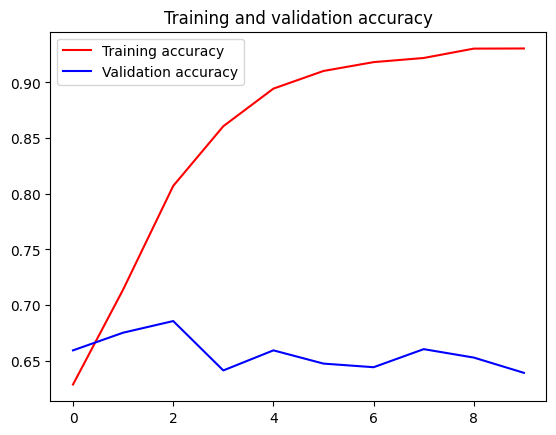

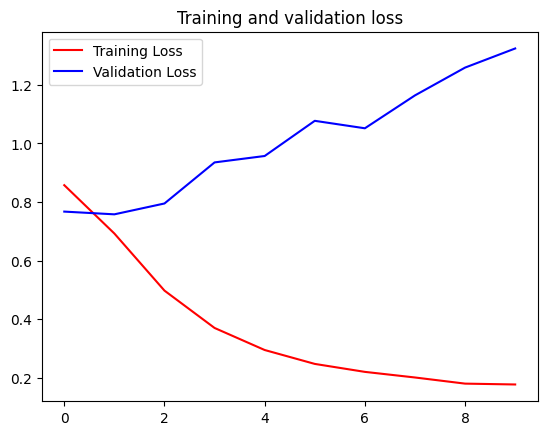

In [73]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()